In [1]:
import math
import numpy as np

from tqdm import tqdm
from glob import glob

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

# 시각화
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

# Network
from net.network import MultiScaleMLPSequential

In [2]:
# CUDA check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [18]:
def compute_derivatives(model, xy_data):
    """
    Get fxx, fyy
    """
    xy_data = xy_data.to(device)
    # Ensure that xy_data has gradient information.
    xy_data.requires_grad_(True)
    
    # Get the model prediction.
    f_pred = model(xy_data)
    
    # Create a tensor of ones with the same shape as f_pred to be used for gradient computation.
    # Reshape the ones tensor to match the shape of f_pred.
    ones = torch.ones(f_pred.shape, device=device, requires_grad=False)
    
    # Compute the first derivatives.
    f_x = torch.autograd.grad(f_pred, xy_data, grad_outputs=ones, create_graph=True)[0][:, 0]
    f_y = torch.autograd.grad(f_pred, xy_data, grad_outputs=ones, create_graph=True)[0][:, 1]
    
    # Compute the second derivatives.
    f_xx = torch.autograd.grad(f_x, xy_data, grad_outputs=ones[:, 0], create_graph=True)[0][:, 0]
    f_yy = torch.autograd.grad(f_y, xy_data, grad_outputs=ones[:, 0], create_graph=True)[0][:, 1]
    
    return f_xx, f_yy

def multiscale_task_loss(model, criterion, xy_daya, f_data, B, C, alpha=0.1):
    """
    추가 도입 예정
    """
    pass


def create_dataloader(data, batch_size, shuffle=True):
    """
    get dataloader
    """
    xy_data = torch.tensor(np.stack([data.T[0], data.T[1]], axis=-1), dtype=torch.float)
    f_data = torch.tensor(data.T[2], dtype=torch.float).view(-1, 1)
    a_data = torch.tensor(data.T[3], dtype=torch.float).view(-1, 1)
    b_data = torch.tensor(data.T[4], dtype=torch.float).view(-1, 1)
    c_data = torch.tensor(data.T[5], dtype=torch.float).view(-1, 1)
    
    dataset = TensorDataset(xy_data, f_data, a_data, b_data, c_data)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return tqdm(loader, desc="Training ", leave=False)


def train_model(model, loader, epochs):
    """
    Implementation func of model training
    """
    
    for epoch in range(epochs):
        model.train()
        batch_loss = 0.0
        batch_data_loss = 0.0  # To record data loss
        batch_pde_loss = 0.0   # To record pde loss
        batch_l1_loss = 0.0

        for batch_xy, batch_f, batch_a, batch_b, batch_c in loader:
            batch_xy = batch_xy.to(device)
            batch_f  = batch_f.to(device)
            batch_a  = batch_a.to(device)
            batch_b  = batch_b.to(device)
            batch_c  = batch_c.to(device)
            
            optimizer.zero_grad()

            # Calculate the losses
            f_pred = model(batch_xy)
            data_loss = criterion(f_pred, batch_f)
            f_xx, f_yy = compute_derivatives(model, batch_xy)
            true_pde = -(batch_b**2+batch_c**2)*f_pred
            pde_loss = alpha * criterion(f_xx + f_yy, true_pde.squeeze())
            l1_loss = l1_regularization(model, lambda_l1=0.01)
            # Combine the losses
            loss = data_loss + pde_loss + l1_loss

            # Backpropagate and optimize
            loss.backward()
            optimizer.step()

            # Record losses
            batch_loss += loss.item()
            batch_data_loss += data_loss.item()
            batch_pde_loss += pde_loss.item()
            batch_l1_loss += l1_loss

        avg_loss = batch_loss / len(loader)
        avg_data_loss = batch_data_loss / len(loader)
        avg_pde_loss = batch_pde_loss / len(loader)
        avg_l1_loss = batch_l1_loss / len(loader)

        # Append the average losses for this epoch to the history
        loss_history.append(avg_loss)
        data_loss_history.append(avg_data_loss)
        pde_loss_history.append(avg_pde_loss)
        l1_loss_history.append(avg_l1_loss)

        scheduler.step() # ReduceLROnPlateau 이면 Loss를 인자로 넣어야함

        # Print the losses every 100 epochs
        if epoch % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch}/{epochs}')
            print(f'Data Loss: {avg_data_loss}, PDE Loss: {avg_pde_loss}, L1_Loss: {avg_l1_loss}')
            print(f"Total Loss: {avg_loss}, LR: {current_lr}")

    # 손실값 그래프를 그립니다.
    print("total loss : ",loss_history[-1])
    print("DATA  loss : ",data_loss_history[-1])
    print("PDE   loss : ",pde_loss_history[-1])
    print("l1    loss : ",l1_loss_history[-1])
    plt.semilogy(loss_history, label="Total")
    plt.semilogy(data_loss_history, label="Data")
    plt.semilogy(pde_loss_history, label="PDE")
    plt.semilogy(l1_loss_history, label="L1")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Epoch vs loss')
    plt.legend()
    plt.show()

def test_inference(model, test_data_path):
    with open(test_data_path, 'rb') as f:
        data = np.load(f,allow_pickle=True)
    x = data.T[0]
    y = data.T[1]
    X = data[:,:2]
    f_true = data.T[2]

    X = torch.tensor(X, dtype=torch.float)
    X = X.to(device)

    with torch.no_grad():
        f_pred = model(X).cpu().numpy().squeeze()

    loss = np.mean(np.sqrt(np.abs(np.square(f_true.reshape(-1))-np.square(f_pred.reshape(-1)))))
    print("Test MSE Loss : ", loss)

    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
    # grid
    xi, yi = np.mgrid[x.min():x.max():500j, y.min():y.max():500j]

    # f_true figure
    rbf = scipy.interpolate.Rbf(x, y, f_true)
    org = rbf(xi, yi)
    img = ax[0].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[0].scatter(x, y, c=f_true)
    ax[0].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)

    # f_pred figure
    rbf = scipy.interpolate.Rbf(x, y, f_pred)
    org = rbf(xi, yi)
    img = ax[1].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[1].scatter(x, y, c=f_pred)
    ax[1].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)
    plt.tight_layout()
    plt.show()
    
    return loss

# L1 규제 적용
def l1_regularization(model, lambda_l1):
    l1_loss = 0
    for param in model.parameters():
        l1_loss += torch.sum(torch.abs(param))
    return lambda_l1 * l1_loss

In [19]:
# 하이퍼 파라미터
batch_size = 50000
shuffle = True # 데이터 셔플
epochs = 3000   # 훈련 epoch
alpha= 0.0001      # Total Loss = Data Loss + alpha * PDE Loss

In [20]:
# Data load
with open("./data/trainXYFABC.npy", 'rb') as f:
    data = np.load(f,allow_pickle=True)
f.close()

# Sample data
print(data.shape) #100000 of [x, y, f(x,y), A, B, C]

(100000, 6)


total loss :  1191.9819946289062
DATA  loss :  9.845919132232666
PDE   loss :  1.7841388583183289
l1    loss :  tensor(1180.3519, device='cuda:0', grad_fn=<DivBackward0>)


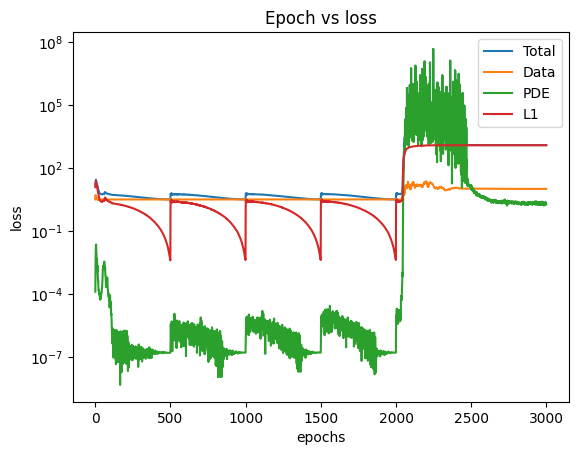

In [43]:
# 손실값 그래프를 그립니다.
print("total loss : ",loss_history[-1])
print("DATA  loss : ",data_loss_history[-1])
print("PDE   loss : ",pde_loss_history[-1])
print("l1    loss : ",l1_loss_history[-1])
plt.semilogy(loss_history, label="Total")
plt.semilogy(data_loss_history, label="Data")
plt.semilogy(pde_loss_history, label="PDE")
plt.semilogy(np.stack([i.cpu().detach().numpy() for i in l1_loss_history]), label="L1")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Epoch vs loss')
plt.legend()
plt.show()

Training :   0%|          | 0/2 [00:00<?, ?it/s]

Train start



Epoch 0/3000
Data Loss: 3.1171305179595947, PDE Loss: 0.00012471941226976924, L1_Loss: 11.898978233337402
Total Loss: 15.016232967376709, LR: 0.1999980280595281
Epoch 10/3000
Data Loss: 3.7517147064208984, PDE Loss: 0.00352116278372705, L1_Loss: 13.613327980041504
Total Loss: 17.368563652038574, LR: 0.1997614893854864
Epoch 20/3000
Data Loss: 3.065017819404602, PDE Loss: 0.00025354313402203843, L1_Loss: 5.6651997566223145
Total Loss: 8.730471134185791, LR: 0.1991316323438437
Epoch 30/3000
Data Loss: 3.0694098472595215, PDE Loss: 6.572713755303994e-05, L1_Loss: 2.9137864112854004
Total Loss: 5.983262062072754, LR: 0.19811094269258908
Epoch 40/3000
Data Loss: 3.0489224195480347, PDE Loss: 9.690127626527101e-05, L1_Loss: 2.416506052017212
Total Loss: 5.465525388717651, LR: 0.19670344862746728
Epoch 50/3000
Data Loss: 3.03312087059021, PDE Loss: 0.0015636656316928566, L1_Loss: 2.628798484802246
Total Loss: 5.663483142852783, LR: 0.19491470488453044
Epoch 60/3000
Data Loss: 2.94050383567810

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

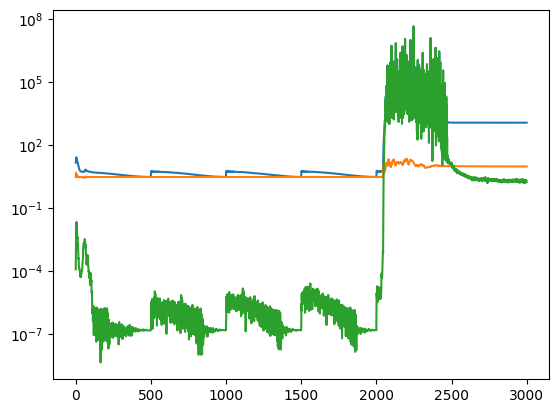

In [21]:
loader = create_dataloader(data, batch_size, shuffle)

model = MultiScaleMLPSequential(
    in_dim=2,
    out_dim=1,
    layers=7,
    neurons=32,
    residual=True,
    subnets=2,
    base_scale=1.1,
    in_scale= [2*np.pi,2*np.pi],
    in_center=[0, 0],
    vec_scen=2,
    vec_size=12,
)
model = model.to(device)
# loss
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=10, verbose=False)
scheduler = CosineAnnealingWarmRestarts(optimizer, 500, T_mult=1, eta_min=0.0002)

# init
loss_history = []
data_loss_history = []
pde_loss_history = []
l1_loss_history = []

best_loss = float('inf')

#### 훈련 시작 ####
print("Train start\n")
train_model(model, loader, epochs)
print("Train end\n")

In [34]:
l1_loss_history[0].cpu().detach().numpy()

array(11.898978, dtype=float32)

array([  11.898978,   14.541011,   17.089378, ..., 1180.3519  ,
       1180.3519  , 1180.3519  ], dtype=float32)

Test MSE Loss :  9.570367897431549


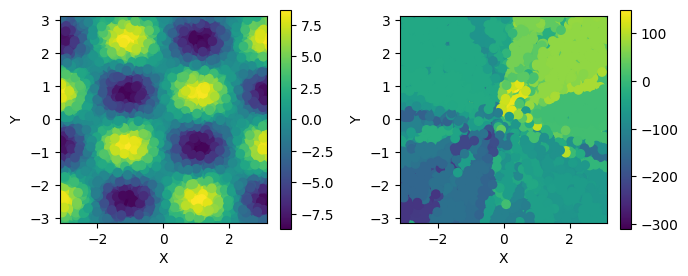

Test MSE Loss :  9.387074023640864


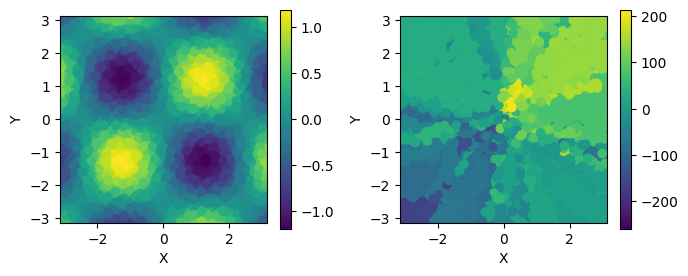

Test MSE Loss :  9.099045192760157


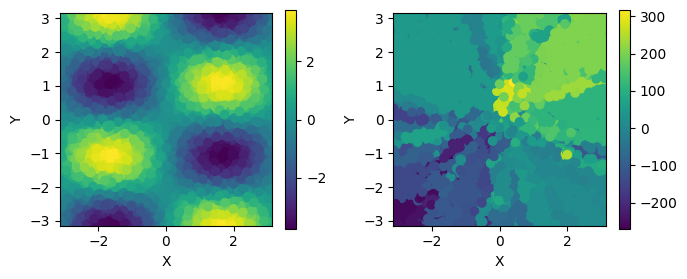

Test MSE Loss :  9.6660049022794


KeyboardInterrupt: 

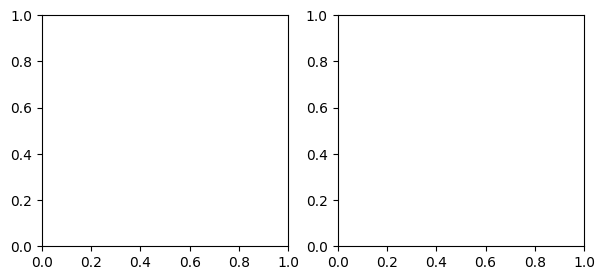

In [42]:
tasks = glob("./data/*_.npy")
for task in tasks:
    test_inference(model, task)